In [3]:
with open("key.txt", "r") as file:
    API_KEY_CLARIN = file.read().strip()

MODELS_ENDPOINT = "https://services.clarin-pl.eu/api/v1/oapi/models"
COMPLETIONS_ENDPOINT = "https://services.clarin-pl.eu/api/v1/oapi/chat/completions"
CLARIN_BASE_URL = "https://services.clarin-pl.eu/api/v1/oapi"

In [4]:
MODEL_ID = "bielik"

In [5]:
import requests
import pandas as pd
import json
import time
import requests

In [6]:
def prompt_chat_custom_temperature(model_id, prompt, temperature = 0.3):
    url = COMPLETIONS_ENDPOINT
    headers = {"Authorization": f"Bearer {API_KEY_CLARIN}", "Content-Type": "application/json"}
    messages = []
    messages.append({"role": "user", "content": prompt})
    data = {
        "model": model_id,
        "messages": messages,
        "temperature": temperature
        #"max_tokens": max_tokens
    }
    response = requests.post(url, json=data, headers=headers)
    if response.status_code == 200:
        try:
            data = response.json()
            if isinstance(data, dict) and "choices" in data and data["choices"]:
                return data["choices"][0].get("message", {}).get("content", None)
            else:
                return None  # Handle unexpected response structure
        except (ValueError, TypeError, AttributeError):
            return None  # Handle cases where response.json() is None or not as expected

In [7]:
df = pd.read_csv("data/dataset.csv", delimiter="|")
df

,en_text,pl_text
0,"Hey, everyone! Wanna hear about Fyresdal?","Ej, ludzie! Chcecie posłuchać o Fyresdal?"
1,"Hey, good folk! Wanna hear what our brave guar...","Ej, ludzie! Chcecie usłyszeć, co nasz dzielny ..."
2,"Shut your trap, dammit!","Stul pysk, do cholery!"
3,Four against one - and you came out alive.,Czterech na jednego. A dałeś radę.
4,Shame to let such a lad waste away behind bars...,"Szkoda, żeby taki chłop marniał za kratkami......"
...,...,...
8375,Farewell.,Bywaj.
8376,Farewell.,Bywaj.
8377,What do you have on offer?,Pokaż mi swoje towary.
8378,Show me what you have in stock.,Pokaż mi swoje towary.


In [ ]:
sampled_df = df.sample(n=100, random_state=28, ignore_index=True)
temperatures = [round(i, 1) for i in [x * 0.1 for x in range(11)]]

for index, row in sampled_df.iterrows():
    polish_text = row["pl_text"]
    for temperature in temperatures:
        translation = prompt_chat_custom_temperature(
            MODEL_ID, 
            f"Translate to english and don't add any explanations, write only translation: '{polish_text}'", 
            temperature
        )
        sampled_df.at[index, f'{MODEL_ID}_translation_{temperature}'] = translation
    
    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} out of {len(sampled_df)} samples...")

sampled_df.to_csv("results/bielik_translations_pl_to_en_temperatures_en_prompt.csv", sep='|', index=False)

Processed 10 out of 100 samples...
Processed 20 out of 100 samples...
Processed 30 out of 100 samples...
Processed 40 out of 100 samples...
Processed 50 out of 100 samples...
Processed 60 out of 100 samples...
Processed 70 out of 100 samples...
Processed 80 out of 100 samples...
Processed 90 out of 100 samples...
Processed 100 out of 100 samples...


In [ ]:
sampled_df = df.sample(n=100, random_state=28, ignore_index=True)

for index, row in sampled_df.iterrows():
    polish_text = row["pl_text"]
    for temperature in temperatures:
        translation = prompt_chat_custom_temperature(
            MODEL_ID, 
            f"Przetłumacz na angielski i nie dodawaj żadnych dodatkowych wyjaśnień, napisz tylko samo tłumaczenie: '{polish_text}'", 
            temperature
        )
        sampled_df.at[index, f'{MODEL_ID}_translation_{temperature}'] = translation
    
    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} out of {len(sampled_df)} samples...")

sampled_df.to_csv("results/bielik_translations_pl_to_en_temperatures_pl_prompt.csv", sep='|', index=False)

Processed 10 out of 100 samples...
Processed 20 out of 100 samples...
Processed 30 out of 100 samples...
Processed 40 out of 100 samples...
Processed 50 out of 100 samples...
Processed 60 out of 100 samples...
Processed 70 out of 100 samples...
Processed 80 out of 100 samples...
Processed 90 out of 100 samples...
Processed 100 out of 100 samples...


In [27]:
translations_metrics_pl_prompt = pd.read_csv('translations_scores/system_translations_temperatures_basic_metrics.csv')
translations_metrics_en_prompt = pd.read_csv('translations_scores/system_translations_temperatures_en_prompt_basic_metrics.csv')
bielik_translations_metrics_pl_to_en_pl_prompt = pd.read_csv('translations_scores/system_bielik_translations_pl_to_en_temperatures_en_prompt_basic_metric.csv')
bielik_translations_metrics_pl_to_en_en_prompt = pd.read_csv('translations_scores/system_bielik_translations_pl_to_en_temperatures_pl_prompt_basic_metric.csv')

In [28]:
bielik_pl_columns = bielik_translations_metrics_pl_to_en_pl_prompt.columns
bielik_en_columns = bielik_translations_metrics_pl_to_en_en_prompt.columns

bielik_translations_metrics_en_to_pl_pl_prompt = translations_metrics_pl_prompt[bielik_pl_columns]
bielik_translations_metrics_en_to_pl_en_prompt = translations_metrics_en_prompt[bielik_en_columns]

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
metrics = ['bleu', 'comet', 'bertscore', 'chrf']

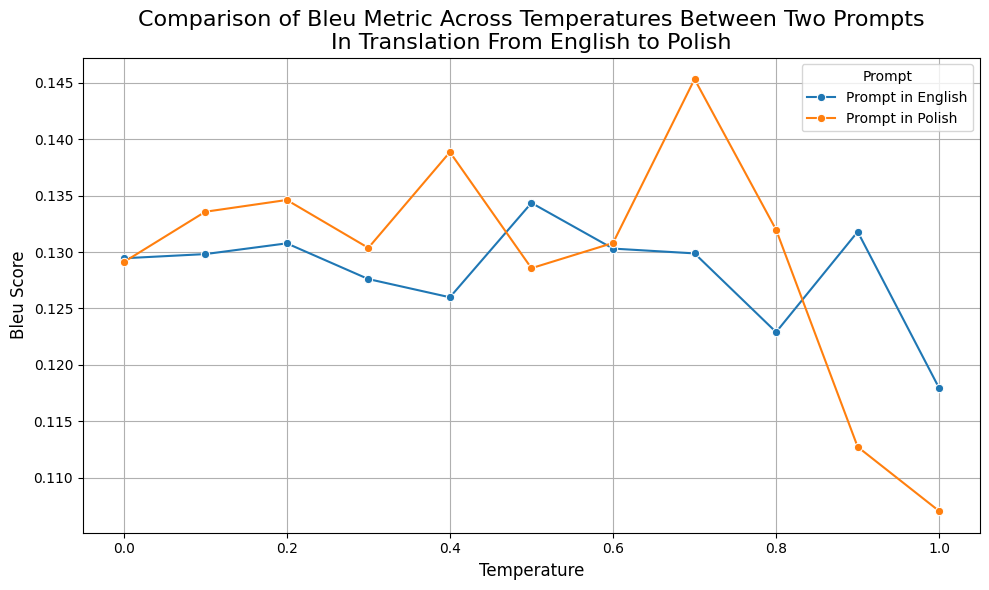

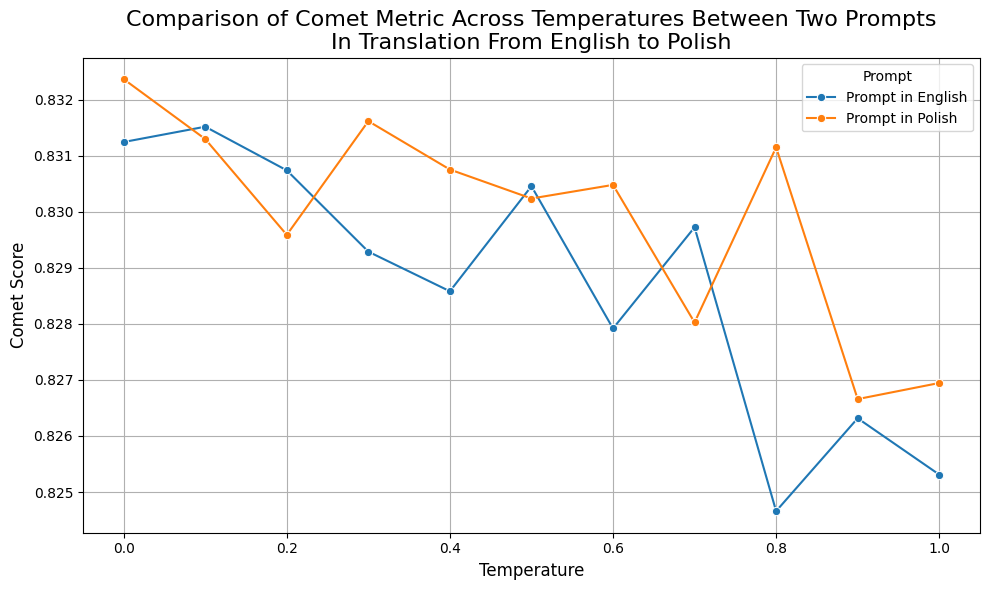

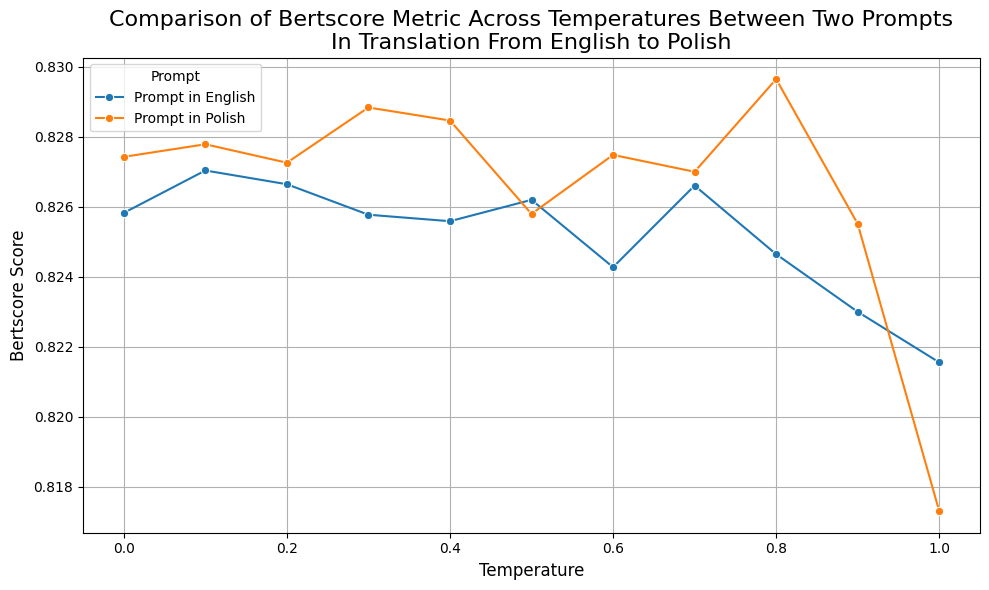

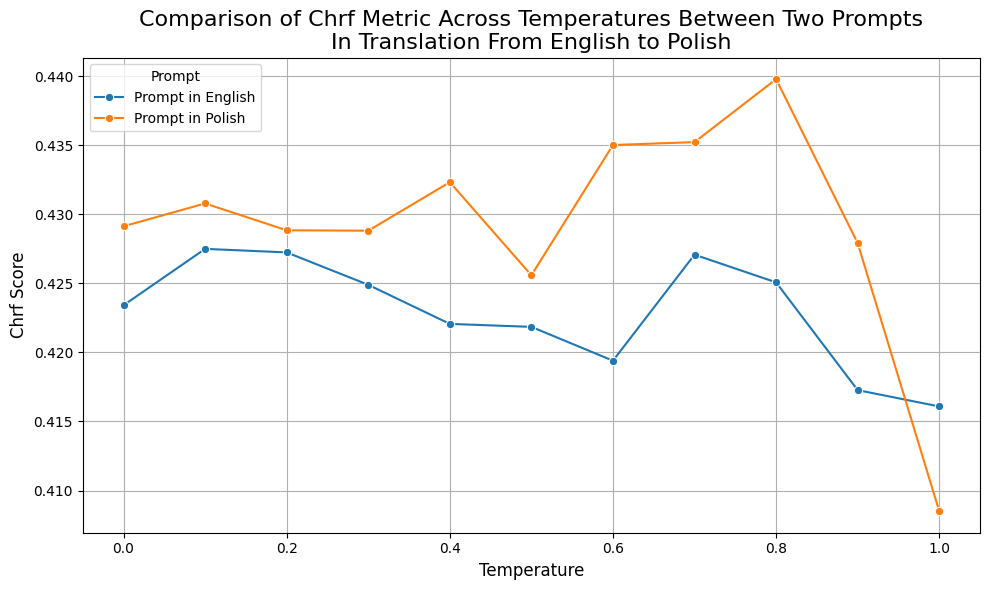

In [31]:
for metric in metrics:
    columns_to_compare_en = [col for col in bielik_translations_metrics_en_to_pl_en_prompt.columns if metric in col.lower()]
    columns_to_compare_pl = [col for col in bielik_translations_metrics_en_to_pl_pl_prompt.columns if metric in col.lower()]

    # Extract model names, temperatures, and values for both datasets
    comparison_data = []

    # Process the English prompt dataset
    for col in columns_to_compare_en:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_en_to_pl_en_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Prompt": "Prompt in English"
        })

    # Process the Polish prompt dataset
    for col in columns_to_compare_pl:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_en_to_pl_pl_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Prompt": "Prompt in Polish"
        })

    # Create a DataFrame for plotting
    comparison_df = pd.DataFrame(comparison_data)

    # Sort the data by Model, Temperature, and Prompt
    comparison_df = comparison_df.sort_values(by=["Temperature", "Prompt"])

    # Plot the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=comparison_df, x="Temperature", y="Value", hue="Prompt", marker="o", palette="tab10")
    plt.title(f"Comparison of {metric.capitalize()} Metric Across Temperatures Between Two Prompts\nIn Translation From English to Polish", fontsize=16)
    plt.xlabel("Temperature", fontsize=12)
    plt.ylabel(f"{metric.capitalize()} Score", fontsize=12)
    plt.legend(title="Prompt", fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.show()

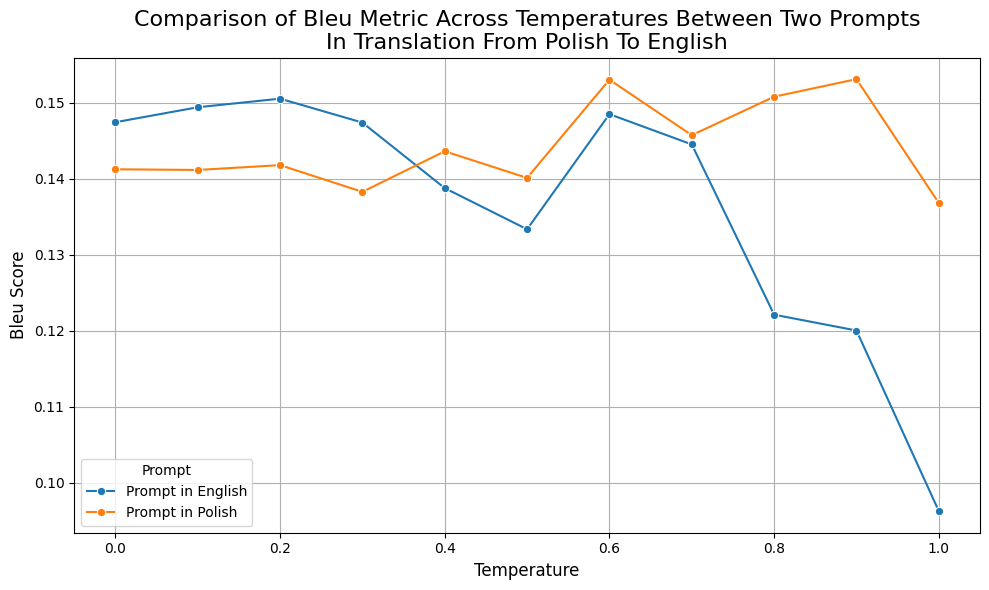

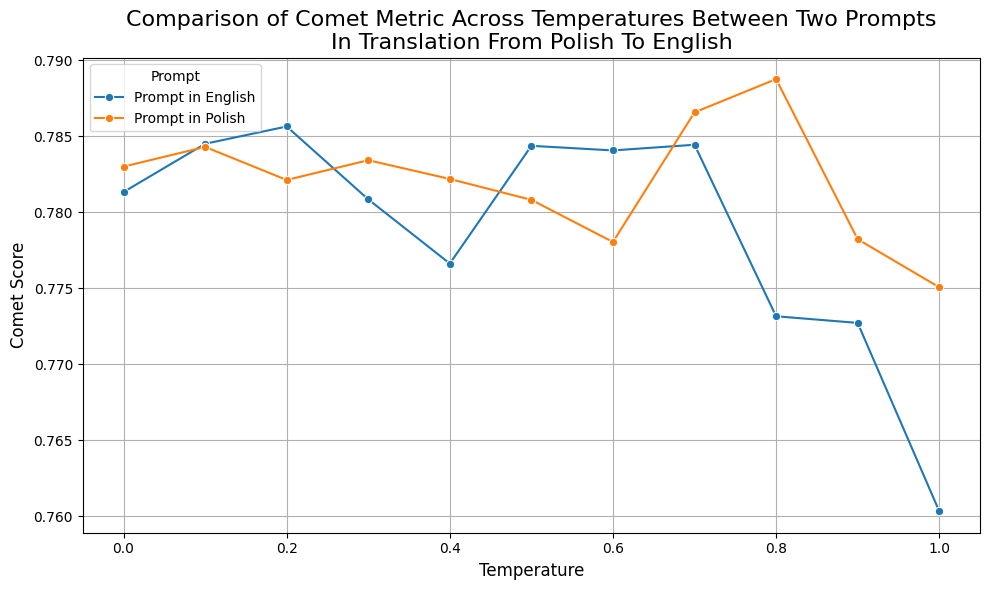

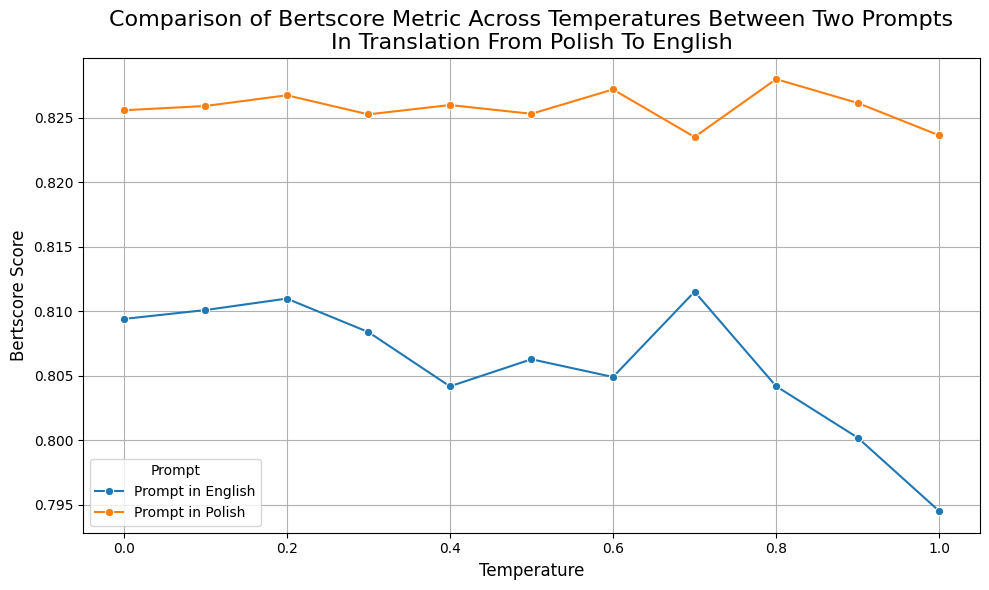

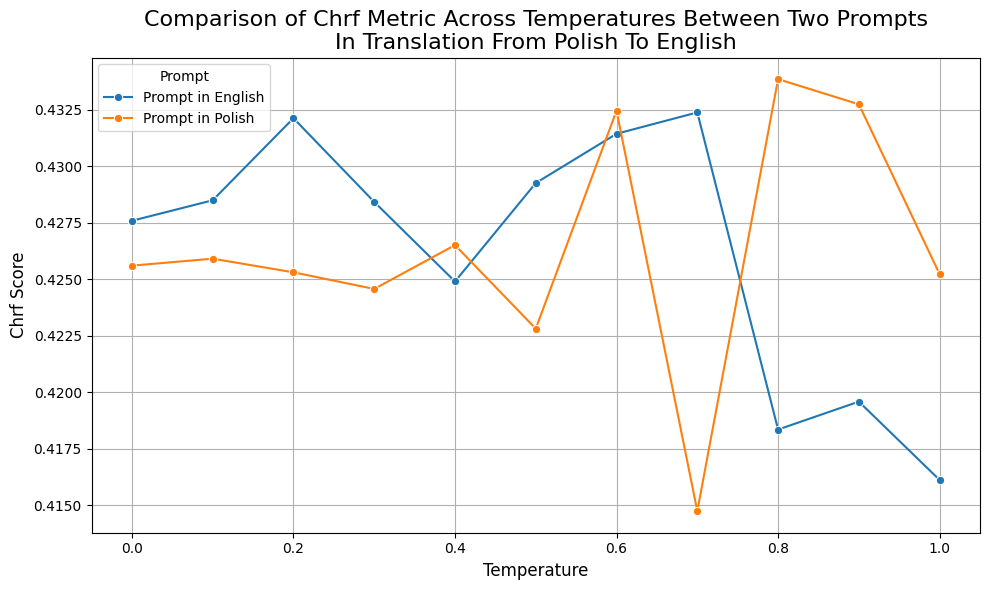

In [32]:
for metric in metrics:
    columns_to_compare_en = [col for col in bielik_translations_metrics_pl_to_en_en_prompt.columns if metric in col.lower()]
    columns_to_compare_pl = [col for col in bielik_translations_metrics_pl_to_en_pl_prompt.columns if metric in col.lower()]

    # Extract model names, temperatures, and values for both datasets
    comparison_data = []

    # Process the English prompt dataset
    for col in columns_to_compare_en:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_pl_to_en_en_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Prompt": "Prompt in English"
        })

    # Process the Polish prompt dataset
    for col in columns_to_compare_pl:
        parts = col.split("_")
        model_name = parts[1]  # Extract the model name
        temperature = float(parts[-1]) if len(parts) > 3 else 0.0  # Extract the temperature
        value = bielik_translations_metrics_pl_to_en_pl_prompt[col].iloc[0]  # Assuming scores are in the first row
        comparison_data.append({
            "Temperature": temperature,
            "Value": value,
            "Prompt": "Prompt in Polish"
        })

    # Create a DataFrame for plotting
    comparison_df = pd.DataFrame(comparison_data)

    # Sort the data by Model, Temperature, and Prompt
    comparison_df = comparison_df.sort_values(by=["Temperature", "Prompt"])

    # Plot the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=comparison_df, x="Temperature", y="Value", hue="Prompt", marker="o", palette="tab10")
    plt.title(f"Comparison of {metric.capitalize()} Metric Across Temperatures Between Two Prompts\nIn Translation From Polish To English", fontsize=16)
    plt.xlabel("Temperature", fontsize=12)
    plt.ylabel(f"{metric.capitalize()} Score", fontsize=12)
    plt.legend(title="Prompt", fontsize=10)
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.show()